In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns

# 1) Prep Data

In [2]:
# Load labeled data
df = pd.read_csv('../labeled/labeledData.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")

df.head()

Dataset shape: (2582, 39)

Column names: ['Unnamed: 0', 'isExoplanet', 'loc_rowid', 'toi', 'tid', 'ra', 'dec', 'st_pmra', 'st_pmraerr1', 'st_pmraerr2', 'st_pmdec', 'st_pmdecerr1', 'st_pmdecerr2', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_trandurh', 'pl_trandurherr1', 'pl_trandurherr2', 'pl_trandep', 'pl_trandeperr1', 'pl_trandeperr2', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_tmagerr1', 'st_tmagerr2', 'st_dist', 'st_disterr1', 'st_disterr2', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_logg', 'st_rad']


,Unnamed: 0,isExoplanet,loc_rowid,toi,tid,ra,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_tmagerr1,st_tmagerr2,st_dist,st_disterr1,st_disterr2,st_teff,st_tefferr1,st_tefferr2,st_logg,st_rad
0,0,F,0.000000,0.121493,0.025595,0.312370,0.441976,1.0,0.014996,1.0,...,0.021821,1.0,0.064991,1.0,1.0,0.701740,0.041584,1.0,1.0,0.235035
1,2828,F,0.367579,0.450701,0.067247,0.331867,0.290722,1.0,0.008355,1.0,...,0.011750,1.0,0.075878,1.0,1.0,0.202685,0.015959,1.0,1.0,0.363145
2,2827,F,0.367449,0.450566,0.121039,0.295884,0.229987,1.0,0.003428,1.0,...,0.010071,1.0,0.037440,1.0,1.0,0.152683,0.018787,1.0,1.0,0.072645
3,2815,F,0.365889,0.449079,0.144183,0.358118,0.357285,1.0,0.004713,1.0,...,0.010071,1.0,0.133968,1.0,1.0,0.359782,0.018963,1.0,1.0,0.188159
4,2814,F,0.365759,0.448944,0.073676,0.339228,0.335514,1.0,0.006427,1.0,...,0.026857,1.0,0.545757,1.0,1.0,0.640394,0.013020,1.0,1.0,0.246945


In [10]:
df['isExoplanet'] = df['isExoplanet'].replace({'F':0,'P':1})

/tmp/ipykernel_6249/1833471994.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isExoplanet'] = df['isExoplanet'].replace({'F':0,'P':1})


In [12]:
# Separate features and target
X = df.drop('isExoplanet', axis=1)  
y = df['isExoplanet']  

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:\n{y.value_counts()}")

Features shape: (2582, 38)
Target shape: (2582,)

Target distribution:
isExoplanet
0    1299
1    1283
Name: count, dtype: int64


In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



## 2) Train XG Boost Classifier

In [25]:

xgb_classifier = XGBClassifier(
    n_estimators=100,         # Number of boosting rounds
    random_state=42,          # Random seed for reproducibility
    n_jobs=-1                 # Use all available processors
)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],  # Depth of each tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Step size for each tree
    'min_child_weight': [1, 2, 3, 4],  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of samples to use for each tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of features to use for each tree
    'n_estimators': [50, 100, 200, 300],  # Number of boosting rounds
}

random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    scoring='accuracy',  # Scoring metric
    cv=3,  # 3-fold cross-validation
    verbose=2,  # Print progress
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

# Get the best model
best_model = random_search.best_estimator_

# Fit the best model on the full training set (if needed)
best_model.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=50, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.6; total tim

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [26]:
# Perform cross-validation with 5 folds
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Scores:")
print(f"\nMean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")


Cross-Validation Scores:

Mean Accuracy: 0.8707
Standard Deviation: 0.0068


In [27]:
#predict
y_pred = best_model.predict(X_test)


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.8839

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       260
           1       0.85      0.93      0.89       257

    accuracy                           0.88       517
   macro avg       0.89      0.88      0.88       517
weighted avg       0.89      0.88      0.88       517



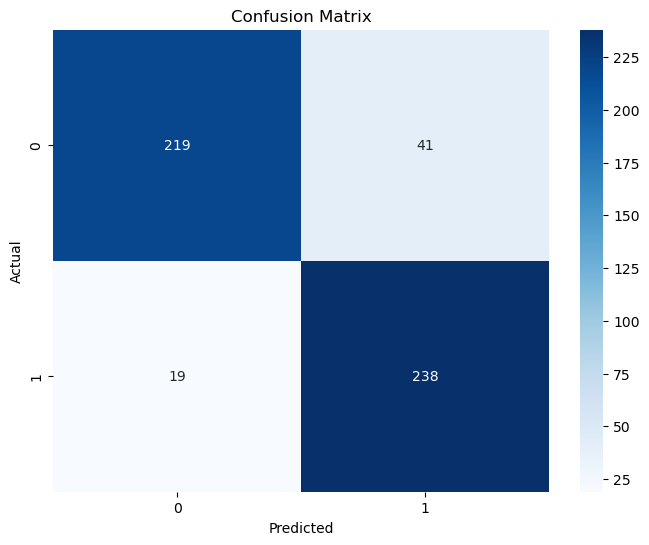

In [28]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Top 10 Most Important Features:
            feature  importance
26           pl_eqt    0.114462
25         pl_insol    0.062521
19  pl_trandurherr1    0.062077
30          st_dist    0.057700
24          pl_rade    0.046603
13   pl_tranmiderr1    0.045007
21       pl_trandep    0.042304
18      pl_trandurh    0.042138
10     st_pmdecerr1    0.041957
37           st_rad    0.040427


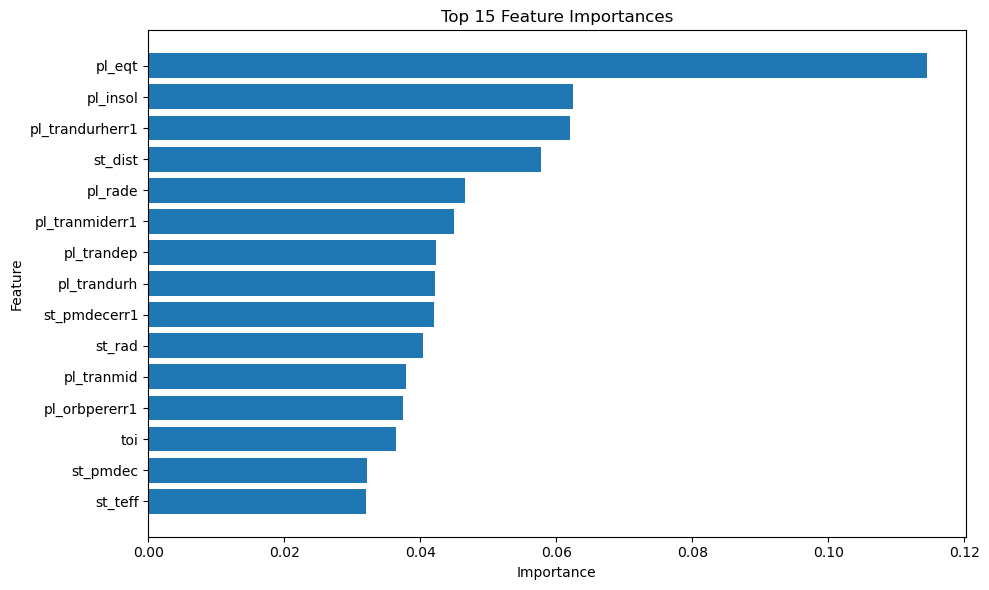

In [30]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()